# Model v16.1

This model was trained and tested with images validated to contain a path (second round of validation).

Roughness metric = 1 second ahead, k-means 2, data split within sessions. Validation set was balanced prior to training in order to encourage a model that learns both categories.

## Set-up

In [ ]:
!pip install wandb

     |████████████████████████████████| 1.8MB 14.7MB/s 
     |████████████████████████████████| 102kB 15.6MB/s 
     |████████████████████████████████| 163kB 59.8MB/s 
     |████████████████████████████████| 81kB 12.9MB/s 
     |████████████████████████████████| 133kB 60.6MB/s 
     |████████████████████████████████| 71kB 12.7MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6490 sha256=0436ccce64fe2252b112f1c9199fbf96b64eba412ef93b5e065375b2a1cd39ff
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built subprocess32


In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 22kB/s 
     |████████████████████████████████| 4.0MB 53.3MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!ls '/gdrive/My Drive/Labeling/Model/'

CompareModels.ipynb  Models.gdoc   split_within_session  v12  v15
ImageFolder.ipynb    Previous	   v10			 v13  v8
Images		     Results.gdoc  v11			 v14  v9


In [ ]:
from fastai.vision import *
import pandas as pd
import numpy as np
import os

In [ ]:
import wandb
from wandb.fastai import WandbCallback

wandb.init(project='roughness-classifier-3')

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Model

#### Load data

In [ ]:
path = '/gdrive/My Drive/Labeling/Model'
folder_path = os.path.join(path, 'split_within_session', 'v16')
image_path = os.path.join(path, 'Images')
label_path = '/gdrive/My Drive/Labeling/LabelsCSV'

In [ ]:
df = pd.read_csv(os.path.join(label_path, 'split_within_session', 'labels_path_validated_split_metric_2.csv'))
df = df.filter(items=['image', 'group_2', 'dataset'])

# Categorical data
df['group_2'] = df['group_2'].astype(int).astype(str)

# Create is_valid column
df['is_valid'] = df['dataset'] == 'valid'

# Training set, filter out dataset column
train = df[df['dataset'] == 'train'].filter(items=['image', 'group_2', 'is_valid'])

# Validation set, filter out dataset column
valid = df[df['dataset'] == 'valid'].filter(items=['image', 'group_2', 'is_valid'])

#### Balance classes

In [ ]:
# Training set
group_0 = train[train['group_2'] == '0']
group_1 = train[train['group_2'] == '1']

print(len(group_0))
print(len(group_1))

3853
1090


In [ ]:
group_0 = group_0[:1200]

train_balanced = group_0.append(group_1)

print(len(train_balanced))
print(len(train_balanced[train_balanced['group_2'] == '0']))
print(len(train_balanced[train_balanced['group_2'] == '1']))

2290
1200
1090


In [ ]:
# Validation set
group_0_v = valid[valid['group_2'] == '0']
group_1_v = valid[valid['group_2'] == '1']

print(len(group_0_v))
print(len(group_1_v))

775
283


In [ ]:
group_0_v = group_0_v[:310]
valid_balanced = group_0_v.append(group_1_v)

print(len(valid_balanced))
print(len(valid_balanced[valid_balanced['group_2'] == '0']))
print(len(valid_balanced[valid_balanced['group_2'] == '1']))

593
310
283


In [ ]:
df_balanced = train_balanced.append(valid_balanced)
print(len(df_balanced))
print(len(df_balanced[df_balanced['is_valid'] == False]))
print(len(df_balanced[df_balanced['is_valid'] == True]))

2883
2290
593


In [ ]:
df_balanced.head()

,image,group_2,is_valid
0,969905035s184ms.jpg,0,False
1,970588340s260ms.jpg,0,False
2,969905551s166ms.jpg,0,False
3,970588244s264ms.jpg,0,False
4,970588138s258ms.jpg,0,False


#### DataBunch

The original image size is 3840 x 2160. We resize (squish) to a smaller image with the same aspect ratio (270 x 480, decreased by a factor of 8) [Link](https://fastai1.fast.ai/vision.transform.html#Data-augmentation-details).

In [ ]:
bs = 64
# bs = 16    # uncomment this line if you run out of memory

In [ ]:
np.random.seed(42)
data = (ImageList
        .from_df(path=image_path, df=df_balanced)
        .split_from_df(col='is_valid')
        .label_from_df(cols='group_2')
        .transform(get_transforms(do_flip=False), size=(270,480))
        .databunch(bs=bs)
        .normalize())

In [ ]:
train_x = data.train_ds.x
train_y = data.train_ds.y
valid_x = data.valid_ds.x
valid_y = data.valid_ds.y

print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))

2290 2290
593 593


In [ ]:
print(data.classes)

['0', '1']


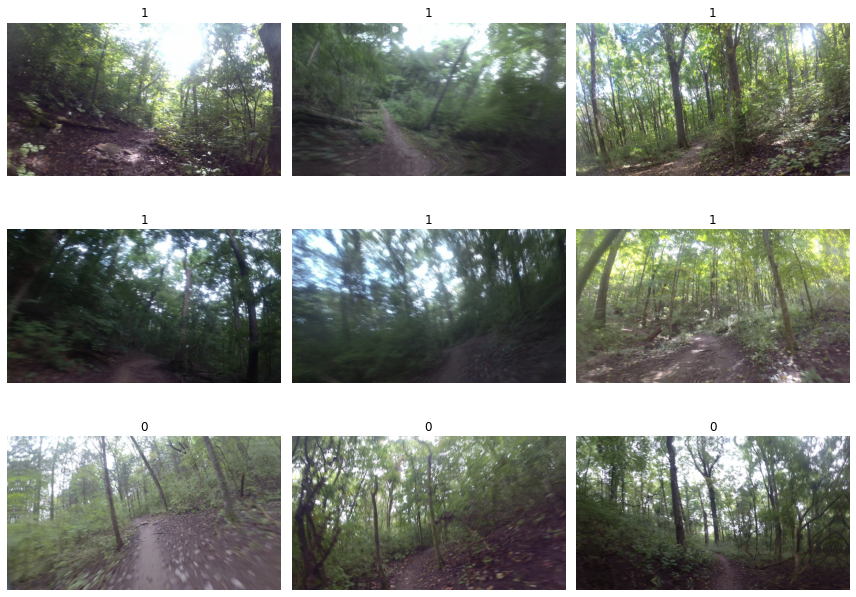

In [ ]:
data.show_batch(rows=3, figsize=(12,9))

#### ResNet50

In [ ]:
arch = models.resnet50
learn = cnn_learner(data, arch, metrics=[accuracy], callback_fns=WandbCallback)
# learn = cnn_learner(data, arch, metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


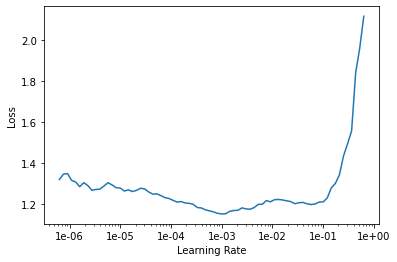

In [ ]:
learn.recorder.plot()

In [ ]:
lr = 0.001

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.206986,0.941700,0.618887,12:04
1,1.063627,1.019895,0.627319,09:49
2,0.948667,0.959602,0.647555,09:48
3,0.811191,0.710719,0.693086,09:52
4,0.746121,0.721133,0.682968,09:51


Better model found at epoch 0 with valid_loss value: 0.9416995644569397.
Better model found at epoch 3 with valid_loss value: 0.7107186317443848.
Loaded best saved model from /content/wandb/run-20210101_220533-9b29kycc/files/bestmodel.pth


In [ ]:
learn.save(os.path.join(folder_path, 'v16-1-stage-1'))

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

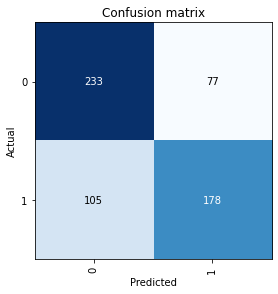

In [ ]:
interp.plot_confusion_matrix()

#### Fine-tune

In [ ]:
learn.load(os.path.join(folder_path, 'v16-1-stage-1'))

In [ ]:
learn.data.batch_size = 16

In [ ]:
learn.data.batch_size

16

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


Loaded best saved model from /content/wandb/run-20210101_220533-9b29kycc/files/bestmodel.pth
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


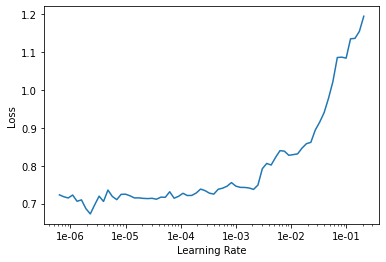

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.706071,0.752423,0.689713,09:57
1,0.689685,0.678674,0.709949,09:55
2,0.645530,0.691595,0.708263,09:49
3,0.594016,0.670668,0.713322,09:52
4,0.625733,0.669524,0.701518,10:00


Better model found at epoch 0 with valid_loss value: 0.752423107624054.
Better model found at epoch 1 with valid_loss value: 0.6786743402481079.
Better model found at epoch 3 with valid_loss value: 0.6706682443618774.
Better model found at epoch 4 with valid_loss value: 0.6695237159729004.
Loaded best saved model from /content/wandb/run-20210101_220533-9b29kycc/files/bestmodel.pth


In [ ]:
learn.save(os.path.join(folder_path, 'v16-1-stage-2'))

In [ ]:
learn.fit_one_cycle(2, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.601786,0.714805,0.713322,09:59
1,0.586767,0.683576,0.708263,09:57


Better model found at epoch 0 with valid_loss value: 0.7148054838180542.
Better model found at epoch 1 with valid_loss value: 0.6835762858390808.
Loaded best saved model from /content/wandb/run-20210101_220533-9b29kycc/files/bestmodel.pth


In [ ]:
learn.load(os.path.join(folder_path, 'v16-1-stage-2'))

In [ ]:
learn.freeze()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

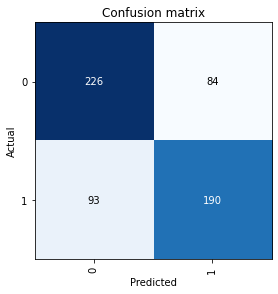

In [ ]:
interp.plot_confusion_matrix()

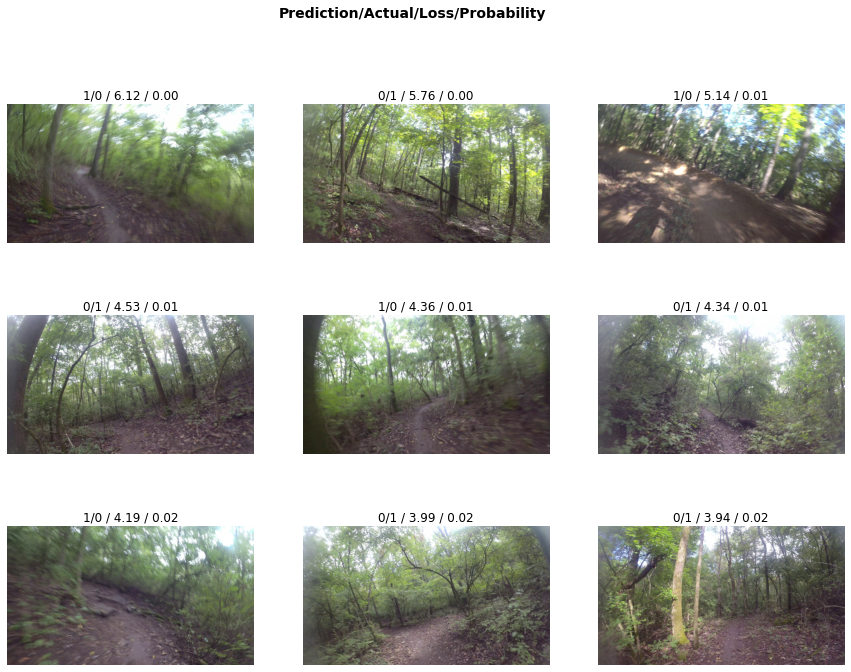

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))